# Lyft's Bay Wheels Data Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

## Investigation Overview

In this investigation, we focused on Lyft’s bike sharing business by analyzing the usage frequency, distance and duration.  We also examined how factors such as the time of usage, user types and Bike Share for All* enrollments could affect the aforementioned variables.

## Dataset Overview

This dataset originally consisted of more than 4.7 million bike trips and spanned over a 2-year time frame.  Main attributes included distance, duration, time of usage (*day of week*, *time period*, *hour*), user types (*subscriber*/*user*) and Bike Share for All enrollments.  500,000 data points were removed from this analysis due to missing or inaccurate information.  

*The Bike Share for All program is offered to Bay Area residents on a limited income.

In [2]:
df = pd.read_csv('lyft_baywheels.csv', dtype={'bike_share_for_all_trip': object, 'rental_access_method': object})

In [3]:
#Convert columns to ordered Category
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
classes = pd.api.types.CategoricalDtype(ordered=True, categories= weekday_order)
df['start_week'] = df.start_week.astype(classes)

period_class_order = ['Morning', 'Afternoon','Evening','Night']
classes = pd.api.types.CategoricalDtype(ordered=True, categories= period_class_order)
df['period'] = df.period.astype(classes)

## Usage by Day of Week and Time Period

Usage is significantly higher on weekdays with Tuesdays, Wednesdays, and Thursdays being the most predominant days. Bikes are also being heavily used in the morning and evening, likely due to rush hour, which we will have a closer examination below.

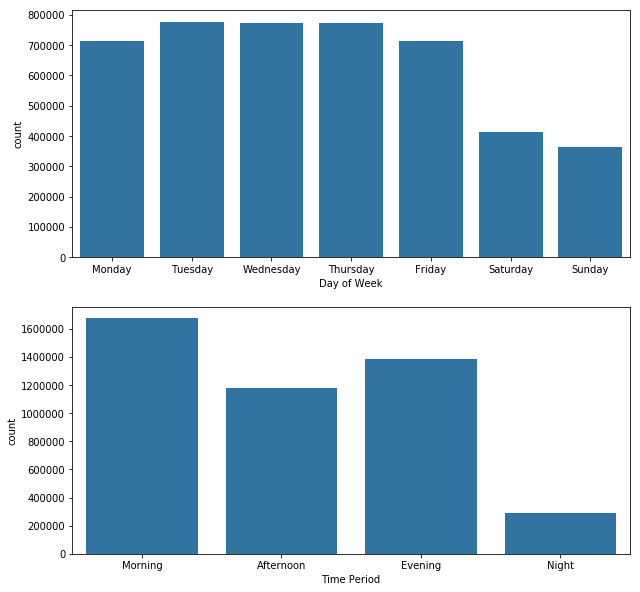

In [4]:
fig, ax = plt.subplots(2,1, figsize=[10,10])
color = sb.color_palette()[0]
sb.countplot(data=df, x='start_week', ax=ax[0], color= color)
sb.countplot(data=df, x='period', ax=ax[1], color= color)
ax[0].set_xlabel('Day of Week')
ax[1].set_xlabel('Time Period');

## Detailed Usage Breakdown

The heatmap below shows a detailed breakdown of our previous observation.  We can see that the peak hours are from Tuesdays to Thursdays 8:00 - 9:00 and 17:00-18:00. Usage drops significantly after midnight and the weekend traffics are mundane in comparison.

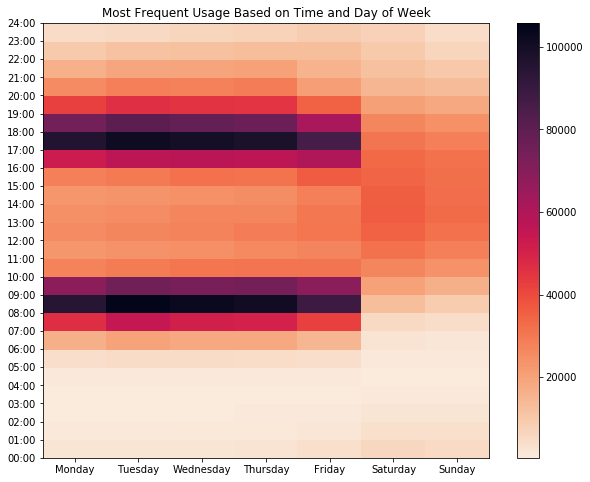

In [5]:
plt.figure(figsize=[10,8])

bins_x= np.arange(0,8,1) #X bins
bins_y = np.arange(0,25,1) #Y bins
x_pos = np.arange(0.5, 7.5, 1) #Position of x labels
x_label = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'] #Create x labels
#Create y labels
y_label=[]
for i in bins_y:
    time = str(i).zfill(2) + str(':00')
    y_label.append(time)

#Main heatmap code
plt.hist2d(data=df, x='start_week_num', y='start_hour', cmap='rocket_r', cmin=0.1, bins=[bins_x,bins_y])
plt.xticks(x_pos,x_label)
plt.yticks(bins_y, y_label)
plt.colorbar()
plt.title('Most Frequent Usage Based on Time and Day of Week');

## Usage by Bike Share for All Enrollment and User Type

Subscribers and non Bike Share for All users follow behaviors that we observed thus far with morning and evening having the highest usage.  Conversely, customers and program participants use their bikes the most in the afternoon.  It is interesting to point out this is also the most popular period for bike rides on the weekends, regardless of user attributes.

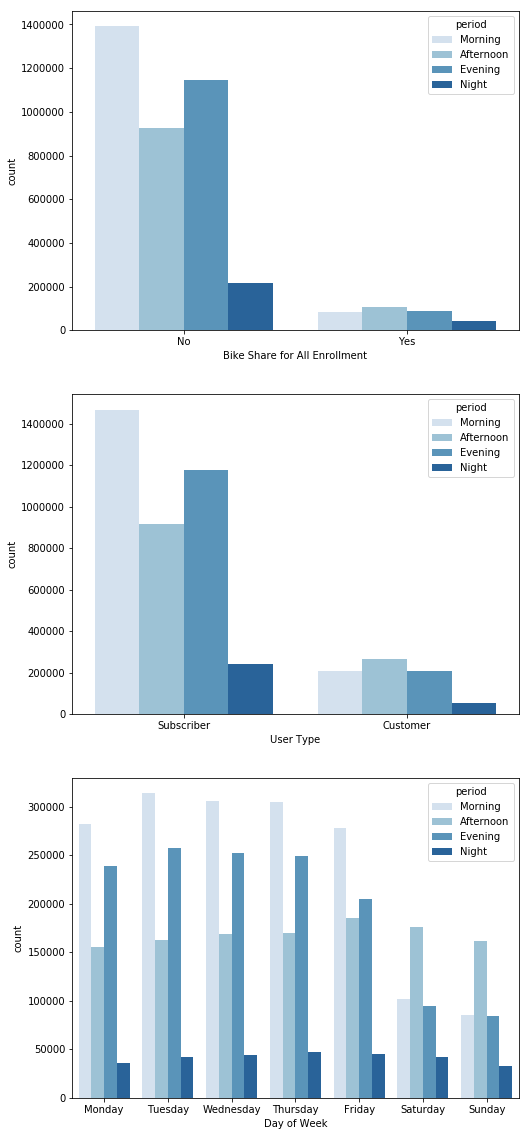

In [6]:
fig, ax = plt.subplots(3,1, figsize=[8,20])
sb.countplot(data=df, x='bike_share_for_all_trip', hue='period', palette='Blues', ax=ax[0])
sb.countplot(data=df, x='user_type', hue='period', palette='Blues', ax=ax[1], order= df.user_type.value_counts().index)
sb.countplot(data=df, x='start_week', hue='period', palette='Blues', ax=ax[2])
ax[0].set_xlabel('Bike Share for All Enrollment')
ax[1].set_xlabel('User Type')
ax[2].set_xlabel('Day of Week');

# Detailed Usage Breakdown by Bike Share for All Enrollment

Compared to users who are not enrolled in the Bike Share for All program, the rush hour is not as obvious for qualified individuals.  The heat map below shows that volume remains high for these users from 8:00 until 20:00 on the weekdays, a 12-hour time span.

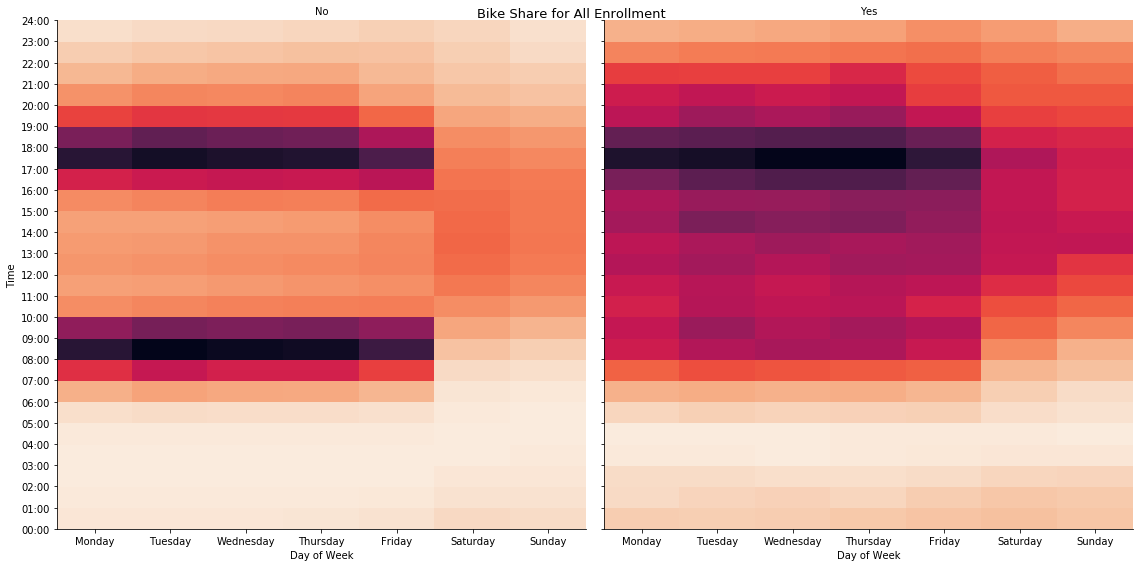

In [7]:
# Quick hack for creating heat maps with seaborn's PairGrid
def heatmap(x,y, **kwargs):
    bins_x= np.arange(0,8,1) #X bins
    bins_y = np.arange(0,25,1) #Y bins

    x_pos = np.arange(0.5, 7.5, 1) #Position of x labels

    x_label = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'] #Create x labels

    #Create y labels
    y_label=[]
    for i in bins_y:
        time = str(i).zfill(2) + str(':00')
        y_label.append(time)

    #Main heatmap code    
    plt.hist2d(data=df, x= x, y= y, cmap='rocket_r', bins=[bins_x,bins_y])
    plt.xticks(x_pos,x_label)
    plt.yticks(bins_y, y_label)

g= sb.FacetGrid(data=df, col='bike_share_for_all_trip', height=8)
g.map(heatmap, 'start_week_num','start_hour')
g.set_xlabels('Day of Week')
g.set_ylabels('Time')
g.set_titles('{col_name}')
g.fig.suptitle('Bike Share for All Enrollment', fontsize=13);

In [8]:
#Define log function
def log_trans(x, inverse=False):
    if not inverse:
        return np.log10(x)
    else:
        return np.power(10,x)

#Sampling 5000 entries so that multivariate plots are clearer and render faster    
np.random.seed(0)
samples = np.random.choice(df.shape[0], 5000, replace = False)
df_samp = df.loc[samples,:]
df_samp['log_min'] = df_samp['duration_min'].apply(log_trans)
df_samp['log_distance'] = df_samp['distance'].apply(log_trans)

## Duration vs Distance Breakdown

The graph below illustrates a strong positive correlation between duration and distance after the log transformation, indicating that a percent increase in one variable does affect the percent increase in the other.

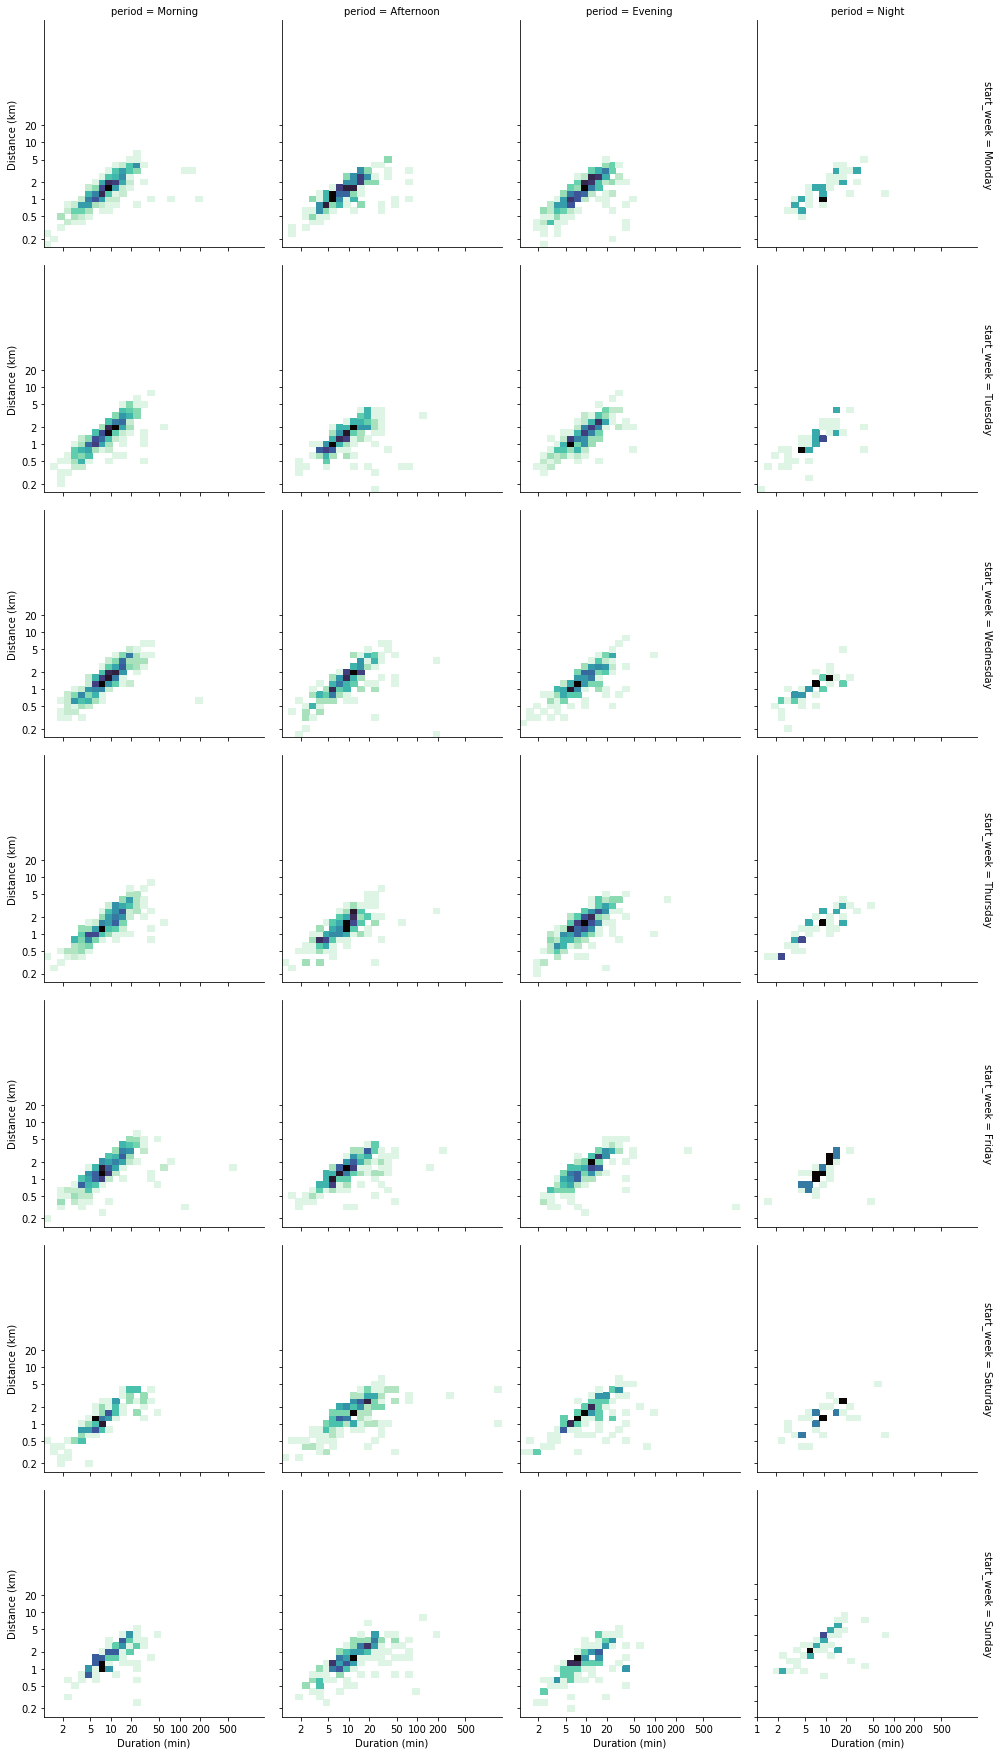

In [9]:
def heatmap2(x,y,**kwargs):
    
    bins_x=np.arange(df_samp.log_min.min(), df_samp.log_min.max()+0.1,0.1)
    bins_y=np.arange(df_samp.log_distance.min(), df_samp.log_min.max()+0.1, 0.1)
    
    tick_locs1= [1,2,5,10,20,50,100,200, 500] # values for duration
    tick_locs2= [0.05,0.1,0.2,0.5,1,2,5,10,20] # values for distance

    plt.hist2d(data=df_samp, x=x, y=y, cmap='mako_r',bins=[bins_x, bins_y], cmin=1)
    plt.xticks(log_trans(tick_locs1),tick_locs1)
    plt.yticks(log_trans(tick_locs2), tick_locs2)
    
g= sb.FacetGrid(data=df_samp, col='period', row='start_week', height=3.5, margin_titles=True)
g.map(heatmap2, 'log_min', 'log_distance')

g.set_xlabels('Duration (min)')
g.set_ylabels('Distance (km)');

## Average Duration and Distance by Day of Week

The point plots below demonstrate that most bike rides take an average of 5 - 20 minutes and 1.2 - 1.8 kilometers. Friday evening and Saturday afternoon rides have the longest duration on average, while rides on Tuesday and Wednesday nights have the shortest duration and distance.

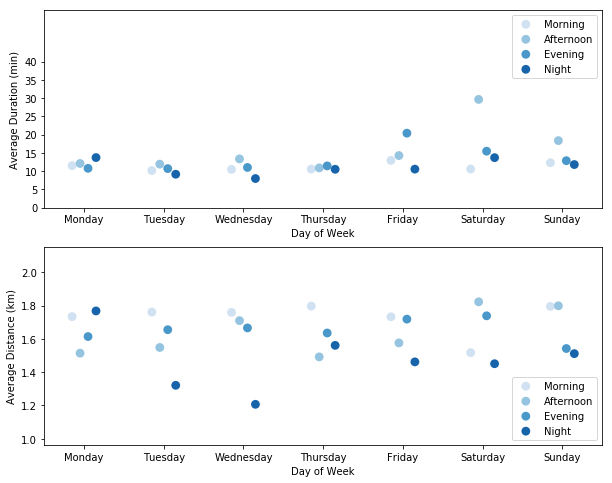

In [10]:
fig, ax = plt.subplots(2,1,figsize=[10,8])

tick_locs = np.arange(0,45,5)

sb.pointplot(data=df_samp, x='start_week', y='duration_min', hue='period', dodge=0.3, palette='Blues', ax=ax[0], linestyles='', errwidth= 0)
sb.pointplot(data=df_samp, x='start_week', y='distance', hue='period', dodge=0.3, palette='Blues', ax=ax[1], linestyles='',errwidth= 0)

ax[0].set_ylabel('Average Duration (min)')
ax[1].set_ylabel('Average Distance (km)')

ax[0].set_xlabel('Day of Week')
ax[1].set_xlabel('Day of Week')

ax[0].set_yticks(tick_locs)

ax[0].legend(loc=1);
ax[1].legend(loc=4);

## Key Insights
+ Generally speaking, the peak hours are from Tuesdays to Thursdays 8:00 - 9:00 and 17:00-18:00
+ Usage on Satudays and Sundays are low in comparsion
+ A percent increase in duration affects the percent increase in distance